## Computer Vision Model for Identifying AI Generated Faces

Text-to-Image Diffusion Models such as DALL-E 2 and Stable Diffusion have become increasingly more robust when it comes to creating realistic photos, including human bodies and faces. These models can be used to edit real photos and videos and create deep fakes, which could lead to an exponential spread of misinformation and the downfall of the integrity of digital media. I designed and implemented a deep learning model leveraging Convolutional Neural Networks to discern between AI-generated and real human faces. The model was trained on real faces along with a custom-made dataset of AI-generated faces made using DALL-E 2 and Stable Diffusion 1.6 and achieved a test accuracy of over 99%.

https://openaccess.thecvf.com/content_CVPRW_2020/papers/w39/Hulzebosch_Detecting_CNN-Generated_Facial_Images_in_Real-World_Scenarios_CVPRW_2020_paper.pdf

https://www.kaggle.com/datasets/denislukovnikov/celebahq256-images-only/data

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from google.colab import drive
from IPython.display import Image, display
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from collections import Counter
import pickle


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Unzipping DALLE images

In [ ]:
!unzip -oq '/content/drive/MyDrive/DALLE_resized_128.zip'

In [ ]:
!ls 'DALLE_resized_128'

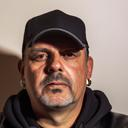

In [ ]:
display(Image('DALLE_resized_128/DALLE_resized_1.jpg'))

## Unzipping Celeb-HQ images

In [ ]:
!unzip -oq '/content/drive/MyDrive/celeb_resized_128.zip'

In [ ]:
!ls 'celeb_resized_128'

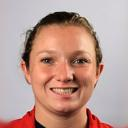

In [ ]:
display(Image('celeb_resized_128/celeb_resized_4.jpg'))

##Unzipping Stable Diffusion images

In [ ]:
!unzip -oq '/content/drive/MyDrive/SD_resized_128.zip'

In [ ]:
!ls 'SD_resized_128'

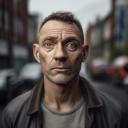

In [ ]:
display(Image('SD_resized_128/SD_resized_4.jpg'))

##Unzipping FairFace images

In [ ]:
!unzip -oq '/content/drive/MyDrive/fairface_resized_128.zip'

In [ ]:
!ls 'fairface_resized_128'

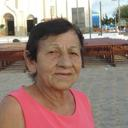

In [ ]:
display(Image('fairface_resized_128/fairface_resized_5.jpg'))

## Processing Images

In [ ]:
def load_and_preprocess_images(folder_path, label, num_images):

  images = []
  labels = []
  # count = 0
  path_list = os.listdir(folder_path)
  # print(len(path_list))
  # print(path_list)
  random.seed(1)
  rand_path_list = random.sample(path_list,num_images)
  print(rand_path_list)

  for filename in tqdm(rand_path_list):
    # count += 1

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    # plt.imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    # img = cv2.resize(img, (128, 128))  # Resize images to a standard size
    # fig = plt.figure()
    # plt.imshow(img)
    # if(count == 12):
    #   print(img.shape)
    #   print(img)
    # print(img)

    img = img / 255.0  # Normalize pixel values to be between 0 and 1

    images.append(img)
    labels.append(label)
    # break
    # if(count == num_images):
    #   break

  return np.array(images), np.array(labels)


def split_data(celeb_image_path, fairface_image_path, DALLE_image_path, SD_image_path, num_celeb, num_fairface, num_DALLE, num_SD):

  celeb_images, celeb_labels = load_and_preprocess_images(celeb_image_path, label = 2, num_images = num_celeb)
  all_images = np.concatenate([celeb_images], axis=0)
  all_labels = np.concatenate([celeb_labels], axis=0)

  if(num_fairface > 0):
    fairface_images, fairface_labels = load_and_preprocess_images(fairface_image_path, label = 3, num_images = num_fairface)
    all_images = np.concatenate([all_images, fairface_images], axis=0)
    all_labels = np.concatenate([all_labels, fairface_labels], axis=0)

  if(num_DALLE > 0):
    DALLE_images, DALLE_labels = load_and_preprocess_images(DALLE_image_path, label = 4, num_images = num_DALLE)
    all_images = np.concatenate([all_images, DALLE_images], axis=0)
    all_labels = np.concatenate([all_labels, DALLE_labels], axis=0)

  if(num_SD > 0):
    SD_images, SD_labels = load_and_preprocess_images(SD_image_path, label = 5, num_images = num_SD)
    all_images = np.concatenate([all_images, SD_images], axis=0)
    all_labels = np.concatenate([all_labels, SD_labels], axis=0)

  # print(all_labels)
  # all_labels = to_categorical(all_labels, 3)
  # print(all_labels)

  x_train, x_val_test, y_train, y_val_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=43)
  x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=43)

  return x_train, y_train, x_val, y_val, x_test, y_test





  # real_x_train, real_x_val_test, real_y_train, real_y_val_test = train_test_split(real_images, real_labels, test_size=0.2, random_state=42)
  # real_x_val, real_x_test, real_y_val, real_y_test = train_test_split(real_x_val_test, real_y_val_test, test_size=0.5, random_state=42)

  # fake_x_train, fake_x_val_test, fake_y_train, fake_y_val_test = train_test_split(fake_images, fake_labels, test_size=0.2, random_state=42)
  # fake_x_val, fake_x_test, fake_y_val, fake_y_test = train_test_split(fake_x_val_test, fake_y_val_test, test_size=0.5, random_state=42)

  # # Combine real and fake images and labels
  # x_train = np.concatenate([real_x_train, fake_x_train], axis=0)
  # y_train = np.concatenate([real_y_train, fake_y_train], axis=0)
  # # x_train, y_train = shuffle(x_train, y_train, random_state=42)

  # x_val = np.concatenate([real_x_val, fake_x_val], axis=0)
  # y_val = np.concatenate([real_y_val, fake_y_val], axis=0)
  # # x_val, y_val = shuffle(x_val, y_val, random_state=42)

  # x_test = np.concatenate([real_x_test, fake_x_test], axis=0)
  # y_test = np.concatenate([real_y_test, fake_y_test], axis=0)
  # # x_test, y_test = shuffle(x_test, y_test, random_state=42)

  # return x_train, y_train, x_val, y_val, x_test, y_test



In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data("celeb_resized_128", "fairface_resized_128", "DALLE_resized_128", "SD_resized_128",
                                                            num_celeb = 6230, num_fairface = 6230, num_DALLE = 6230, num_SD = 6230)
# print(f"Training: {Counter(y_train)}")
# print(f"Validation: {Counter(y_val)}")
# print(f"Testing: {Counter(y_test)}")
print(y_test)

# print(x_train)
# print(y_train)

['celeb_resized_10487.jpg', 'celeb_resized_5872.jpg', 'celeb_resized_749.jpg', 'celeb_resized_8256.jpg', 'celeb_resized_2162.jpg', 'celeb_resized_6797.jpg', 'celeb_resized_1799.jpg', 'celeb_resized_1065.jpg', 'celeb_resized_10058.jpg', 'celeb_resized_280.jpg', 'celeb_resized_1119.jpg', 'celeb_resized_4673.jpg', 'celeb_resized_5619.jpg', 'celeb_resized_1108.jpg', 'celeb_resized_9862.jpg', 'celeb_resized_10126.jpg', 'celeb_resized_5216.jpg', 'celeb_resized_4943.jpg', 'celeb_resized_8867.jpg', 'celeb_resized_369.jpg', 'celeb_resized_3973.jpg', 'celeb_resized_9659.jpg', 'celeb_resized_5593.jpg', 'celeb_resized_1639.jpg', 'celeb_resized_10203.jpg', 'celeb_resized_7737.jpg', 'celeb_resized_9332.jpg', 'celeb_resized_6656.jpg', 'celeb_resized_8712.jpg', 'celeb_resized_582.jpg', 'celeb_resized_5744.jpg', 'celeb_resized_5219.jpg', 'celeb_resized_8127.jpg', 'celeb_resized_144.jpg', 'celeb_resized_6527.jpg', 'celeb_resized_1336.jpg', 'celeb_resized_9280.jpg', 'celeb_resized_3492.jpg', 'celeb_resiz

100%|██████████| 6230/6230 [00:06<00:00, 919.15it/s] 


['fairface_resized_2785.jpg', 'fairface_resized_4412.jpg', 'fairface_resized_3169.jpg', 'fairface_resized_4255.jpg', 'fairface_resized_3658.jpg', 'fairface_resized_1796.jpg', 'fairface_resized_1980.jpg', 'fairface_resized_5905.jpg', 'fairface_resized_5560.jpg', 'fairface_resized_2551.jpg', 'fairface_resized_514.jpg', 'fairface_resized_610.jpg', 'fairface_resized_3306.jpg', 'fairface_resized_1960.jpg', 'fairface_resized_3895.jpg', 'fairface_resized_4326.jpg', 'fairface_resized_3938.jpg', 'fairface_resized_1756.jpg', 'fairface_resized_4582.jpg', 'fairface_resized_5782.jpg', 'fairface_resized_3048.jpg', 'fairface_resized_3054.jpg', 'fairface_resized_3961.jpg', 'fairface_resized_6027.jpg', 'fairface_resized_744.jpg', 'fairface_resized_4062.jpg', 'fairface_resized_5346.jpg', 'fairface_resized_5998.jpg', 'fairface_resized_3162.jpg', 'fairface_resized_3939.jpg', 'fairface_resized_2370.jpg', 'fairface_resized_2838.jpg', 'fairface_resized_5241.jpg', 'fairface_resized_4264.jpg', 'fairface_resize

100%|██████████| 6230/6230 [00:05<00:00, 1114.17it/s]


['DALLE_resized_6238.jpg', 'DALLE_resized_1833.jpg', 'DALLE_resized_1338.jpg', 'DALLE_resized_3874.jpg', 'DALLE_resized_5734.jpg', 'DALLE_resized_1325.jpg', 'DALLE_resized_4227.jpg', 'DALLE_resized_3575.jpg', 'DALLE_resized_4028.jpg', 'DALLE_resized_4606.jpg', 'DALLE_resized_5516.jpg', 'DALLE_resized_5377.jpg', 'DALLE_resized_6221.jpg', 'DALLE_resized_924.jpg', 'DALLE_resized_5924.jpg', 'DALLE_resized_5424.jpg', 'DALLE_resized_3526.jpg', 'DALLE_resized_3179.jpg', 'DALLE_resized_3896.jpg', 'DALLE_resized_2175.jpg', 'DALLE_resized_5146.jpg', 'DALLE_resized_1610.jpg', 'DALLE_resized_1905.jpg', 'DALLE_resized_2077.jpg', 'DALLE_resized_216.jpg', 'DALLE_resized_4273.jpg', 'DALLE_resized_66.jpg', 'DALLE_resized_6092.jpg', 'DALLE_resized_3276.jpg', 'DALLE_resized_135.jpg', 'DALLE_resized_5492.jpg', 'DALLE_resized_858.jpg', 'DALLE_resized_4585.jpg', 'DALLE_resized_4478.jpg', 'DALLE_resized_2457.jpg', 'DALLE_resized_5622.jpg', 'DALLE_resized_701.jpg', 'DALLE_resized_5422.jpg', 'DALLE_resized_444

100%|██████████| 6230/6230 [00:05<00:00, 1089.33it/s]


['SD_resized_5131.jpg', 'SD_resized_4904.jpg', 'SD_resized_3900.jpg', 'SD_resized_3916.jpg', 'SD_resized_6133.jpg', 'SD_resized_542.jpg', 'SD_resized_4805.jpg', 'SD_resized_2310.jpg', 'SD_resized_4395.jpg', 'SD_resized_5725.jpg', 'SD_resized_2316.jpg', 'SD_resized_2985.jpg', 'SD_resized_5150.jpg', 'SD_resized_2295.jpg', 'SD_resized_5681.jpg', 'SD_resized_771.jpg', 'SD_resized_649.jpg', 'SD_resized_624.jpg', 'SD_resized_534.jpg', 'SD_resized_4165.jpg', 'SD_resized_5885.jpg', 'SD_resized_4507.jpg', 'SD_resized_5800.jpg', 'SD_resized_2438.jpg', 'SD_resized_954.jpg', 'SD_resized_4966.jpg', 'SD_resized_5605.jpg', 'SD_resized_5944.jpg', 'SD_resized_5548.jpg', 'SD_resized_3401.jpg', 'SD_resized_4649.jpg', 'SD_resized_5266.jpg', 'SD_resized_1598.jpg', 'SD_resized_1149.jpg', 'SD_resized_4471.jpg', 'SD_resized_2029.jpg', 'SD_resized_1349.jpg', 'SD_resized_2452.jpg', 'SD_resized_2264.jpg', 'SD_resized_5163.jpg', 'SD_resized_4938.jpg', 'SD_resized_255.jpg', 'SD_resized_5877.jpg', 'SD_resized_1800.

100%|██████████| 6230/6230 [00:05<00:00, 1074.68it/s]


[3 2 2 ... 5 4 3]


2


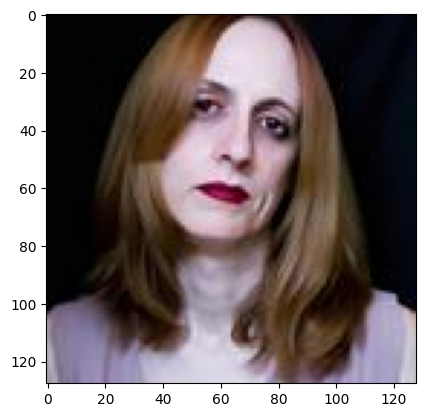

In [ ]:
print(y_train[1])
plt.imshow(x_train[1])

3


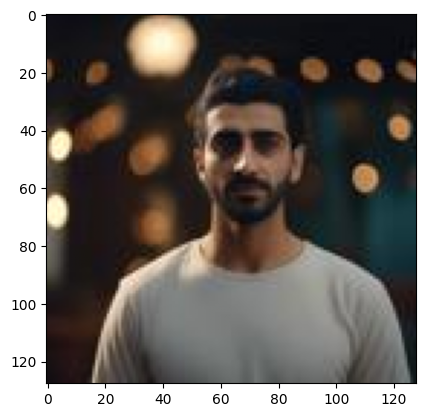

In [ ]:
print(y_train[65])
plt.imshow(x_train[65])

0


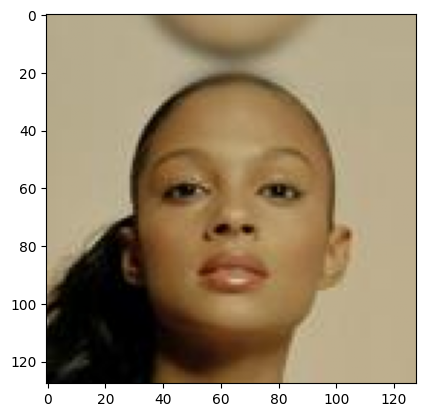

In [ ]:
print(y_train[76])
plt.imshow(x_train[76])

In [ ]:
def train_cnn(x_train, y_train, x_val, y_val, dropout, epochs):

  model = Sequential()
  model.add(layers.Conv2D(32, (3,3), padding = "same", kernel_initializer='he_uniform', activation = 'relu', input_shape = (128,128,3)))
  model.add(BatchNormalization())
  model.add(layers.Conv2D(32, (3,3), padding = "same", kernel_initializer='he_uniform', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.MaxPool2D(2,2))
  model.add(layers.Dropout(dropout))

  model.add(layers.Conv2D(64, (3,3), padding = "same", kernel_initializer='he_uniform', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.Conv2D(64, (3,3), padding = "same", kernel_initializer='he_uniform', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.MaxPool2D(2,2))
  model.add(layers.Dropout(dropout))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, kernel_initializer='he_uniform', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  # model.add(layers.Dense(3, activation = 'softmax'))

  adam = Adam(learning_rate = 0.001)

  model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
  # model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  # reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10)

  # start = time.time()
  history = model.fit(x_train,
                      y_train,
                      batch_size = 64,
                      validation_data = (x_val, y_val),
                      epochs = epochs
                      )

  return model, history

In [ ]:
epochs = 20
dropout = 0.01
model, history = train_cnn(x_train, y_train, x_val, y_val, dropout, epochs)

model.save('/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_and_SD_128_model.keras')
with open('/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_and_SD_128_hist.pkl', 'wb') as file:
  pickle.dump(history, file)

Epoch 1/20
312/312 [==============================] - 30s 50ms/step - loss: 0.1652 - accuracy: 0.9366 - val_loss: 0.2115 - val_accuracy: 0.9105
Epoch 2/20
312/312 [==============================] - 14s 43ms/step - loss: 0.0512 - accuracy: 0.9833 - val_loss: 0.0694 - val_accuracy: 0.9719
Epoch 3/20
312/312 [==============================] - 13s 43ms/step - loss: 0.0205 - accuracy: 0.9942 - val_loss: 0.0452 - val_accuracy: 0.9815
Epoch 4/20
312/312 [==============================] - 13s 43ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0568 - val_accuracy: 0.9795
Epoch 5/20
312/312 [==============================] - 14s 43ms/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 0.1069 - val_accuracy: 0.9643
Epoch 6/20
312/312 [==============================] - 13s 43ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.0410 - val_accuracy: 0.9835
Epoch 7/20
312/312 [==============================] - 13s 43ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0349 - val_accuracy:

In [ ]:
# test_loss, test_acc = model.evaluate(x_test, y_test)
# print(f"Test Accuracy: {test_acc}")

def evaluate_model(model_file, history_file, x_test, y_test, title):
  hist_file = open(history_file, 'rb')
  history = pickle.load(hist_file)

  plt.figure()
  plt.title(f"Training History of {title} Model")
  plt.plot(history.history['accuracy'], label='Training Acc')
  plt.plot(history.history['val_accuracy'], label='Val Acc')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.show()


  loaded_model = tf.keras.models.load_model(model_file)

  # true = np.argmax(y_test, axis=1)
  # # print(true)
  # preds = np.argmax(loaded_model.predict(x_test), axis=1)
  # # print(preds)
  # print(y_test)
  y_test_binary = []
  dic = {2:0, 3:0, 4:1, 5:1}
  for n in y_test:
    y_test_binary.append(dic[n])

  # print(y_test_binary)
  # print(y_test)

  true = y_test_binary #y_test
  preds = loaded_model.predict(x_test)
  preds = np.round(preds).flatten()

  dic2 = {2:"Celeb", 3:"FairFace", 4:"DALLE", 5:"SD"}
  for i in range(len(preds)):
    if(preds[i] != true[i]):
      print(f"{i} -> Predicted: {preds[i]} | Actual: {dic2[y_test[i]]}")
      # fig = plt.figure()
      # plt.imshow(x_test[i])



  prec_tot = metrics.precision_score(true, preds, labels = [0,1], average = 'weighted')
  recall_tot = metrics.recall_score(true, preds, labels = [0,1], average = 'weighted')
  f1_tot = metrics.f1_score(true, preds, labels = [0,1], average = 'weighted')

  prec = metrics.precision_score(true, preds, labels = [0,1], average = None)
  recall = metrics.recall_score(true, preds, labels = [0,1], average = None)
  f1 = metrics.f1_score(true, preds, labels = [0,1], average = None)

  prec = np.insert(prec, 0, prec_tot)
  recall = np.insert(recall, 0, recall_tot)
  f1 = np.insert(f1, 0, f1_tot)

  scores = {
    'Precision': prec,
    'Recall': recall,
    'F1': f1
    }

  scores_df = pd.DataFrame(scores, index = ["Overall", "Real", "Fake"]).round(4)
  print(scores_df)

  conf_mat = metrics.confusion_matrix(y_test, preds, labels = [0,1,2,3,4,5])
  fig, (ax1) = plt.subplots(figsize=(5, 5))
  ax1.set_title(title)
  ax1.set_xlabel('Predicted')
  ax1.set_ylabel('True')
  sns.heatmap(conf_mat, annot=True, fmt='g', xticklabels=["Real", "Fake", "Celeb", "FairFace", "DALLE", "SD"], yticklabels=["Real", "Fake", "Celeb", "FairFace", "DALLE", "SD"], ax = ax1)
  plt.show()





## Celeb vs DALLE

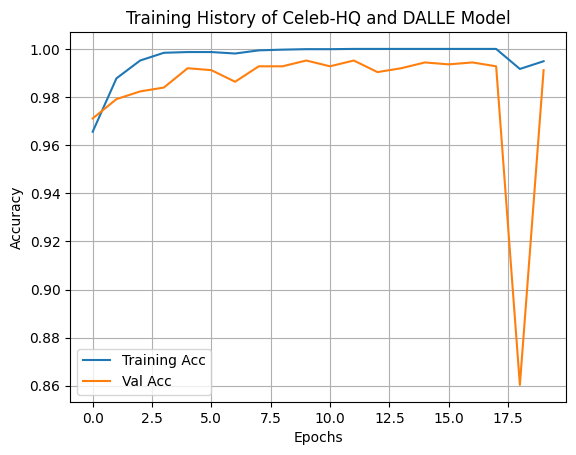

39/39 [==============================] - 0s 6ms/step
         Precision  Recall      F1
Overall     0.9912  0.9912  0.9912
Real        0.9856  0.9968  0.9912
DALLE       0.9968  0.9857  0.9912


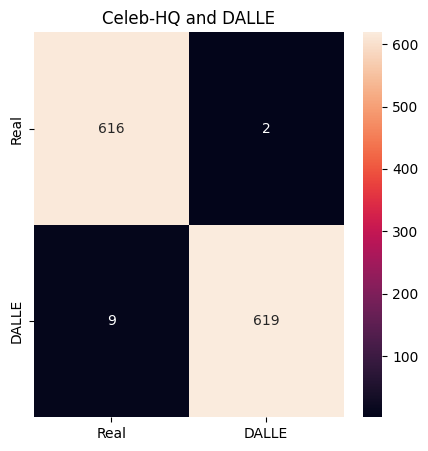

In [ ]:
evaluate_model('/content/drive/MyDrive/celeb_vs_DALLE_128_model.keras',
               '/content/drive/MyDrive/celeb_vs_DALLE_128_hist.pkl',
               x_test, y_test,
               title = "Celeb-HQ and DALLE")

##Celeb vs Stable Diff

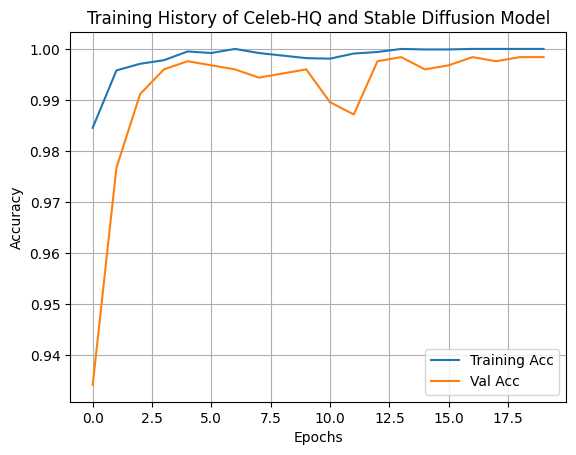

39/39 [==============================] - 0s 6ms/step
         Precision  Recall      F1
Overall     0.9992  0.9992  0.9992
Real        0.9984  1.0000  0.9992
SD          1.0000  0.9984  0.9992


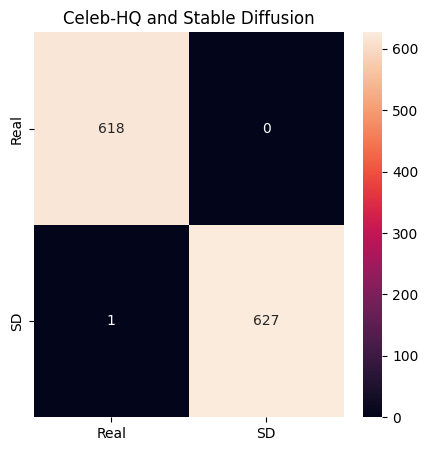

In [ ]:
evaluate_model('/content/drive/MyDrive/celeb_vs_SD_128_model.keras',
               '/content/drive/MyDrive/celeb_vs_SD_128_hist.pkl',
               x_test, y_test,
               title = "Celeb-HQ and Stable Diffusion")

##Celeb vs DALLE and Stable Diff but binary class

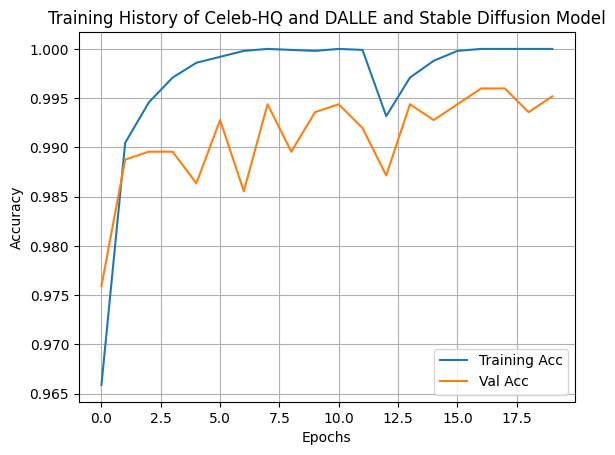

39/39 [==============================] - 0s 6ms/step
         Precision  Recall      F1
Overall     0.9944  0.9944  0.9944
Real        0.9967  0.9919  0.9943
Fake        0.9921  0.9968  0.9944


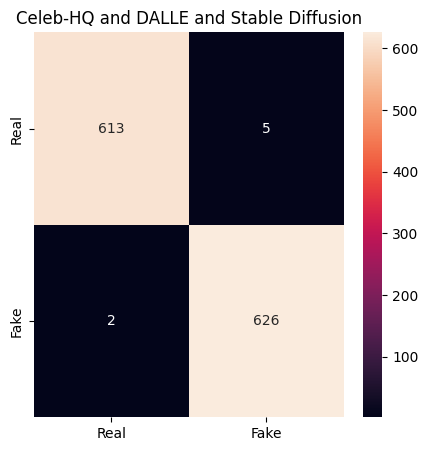

In [ ]:
evaluate_model('/content/drive/MyDrive/celeb_vs_DALLE_and_SD_128_model.keras',
               '/content/drive/MyDrive/celeb_vs_DALLE_and_SD_128_hist.pkl',
               x_test, y_test,
               title = "Celeb-HQ and DALLE and Stable Diffusion")

##Celeb vs DALLE and Stable Diff using categories

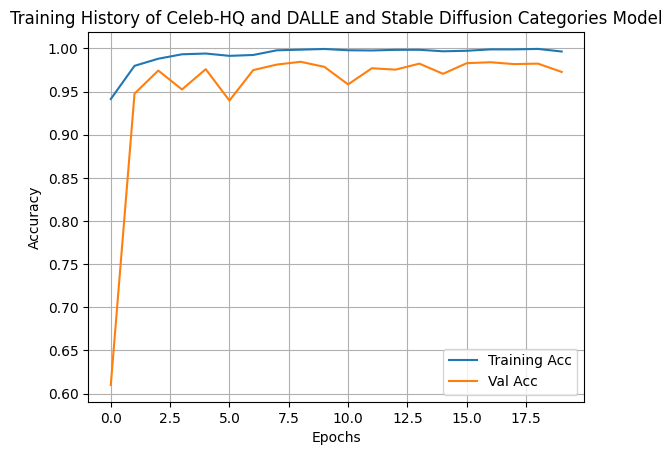

59/59 [==============================] - 0s 6ms/step
         Precision  Recall      F1
Overall     0.9758  0.9754  0.9755
Real        0.9875  0.9739  0.9807
DALLE       0.9490  0.9803  0.9644
SD          0.9900  0.9721  0.9810


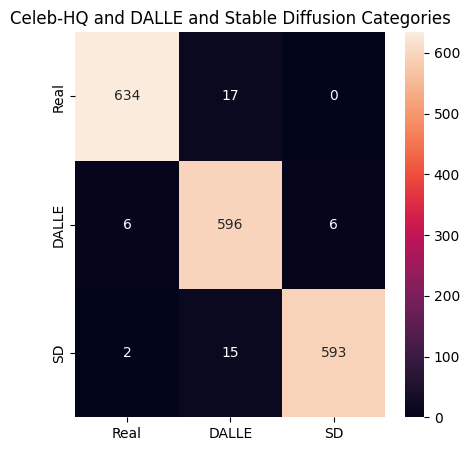

In [ ]:
evaluate_model('/content/drive/MyDrive/celeb_vs_DALLE_and_SD_128_model_cat.keras',
               '/content/drive/MyDrive/celeb_vs_DALLE_and_SD_128_hist_cat.pkl',
               x_test, y_test,
               title = "Celeb-HQ and DALLE and Stable Diffusion Categories")

##FairFace vs DALLE and Stable Diff using categories

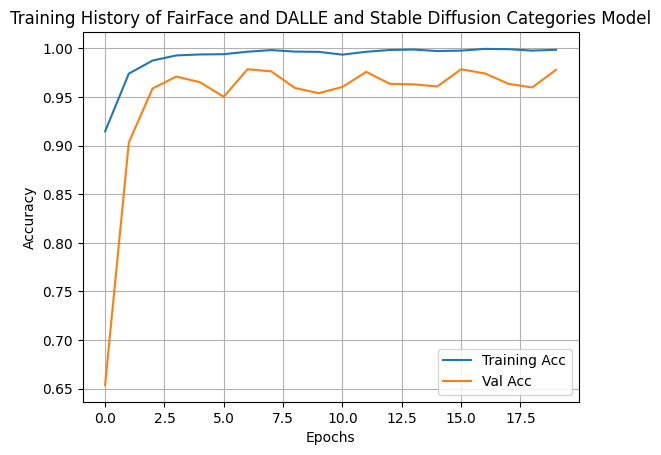

59/59 [==============================] - 0s 5ms/step
         Precision  Recall      F1
Overall     0.9829  0.9829  0.9829
Real        0.9817  0.9877  0.9847
DALLE       0.9738  0.9770  0.9754
SD          0.9934  0.9836  0.9885


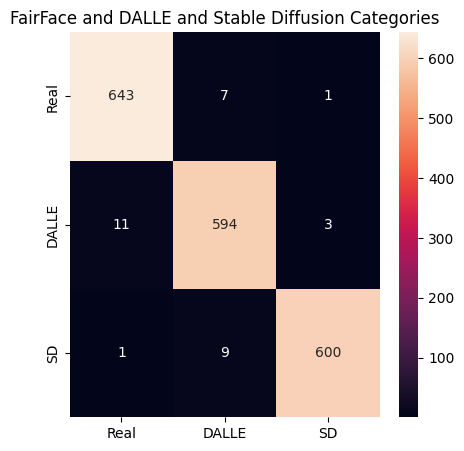

In [ ]:
evaluate_model('/content/drive/MyDrive/fairface_vs_DALLE_and_SD_128_model_cat.keras',
               '/content/drive/MyDrive/fairface_vs_DALLE_and_SD_128_hist_cat.pkl',
               x_test, y_test,
               title = "FairFace and DALLE and Stable Diffusion Categories")

##Fairface vs DALLE

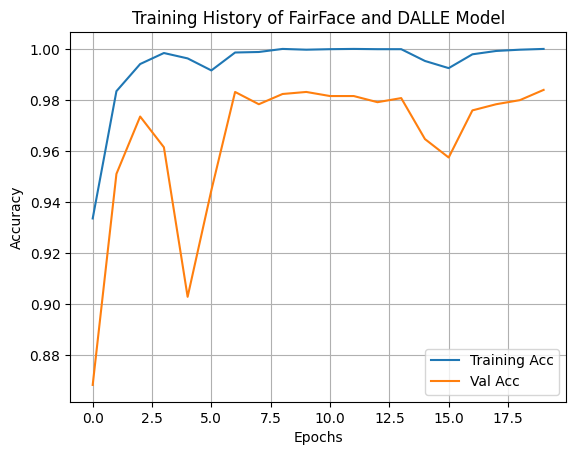

39/39 [==============================] - 0s 6ms/step
         Precision  Recall      F1
Overall     0.9832  0.9831  0.9831
Real        0.9761  0.9903  0.9831
DALLE       0.9903  0.9761  0.9832


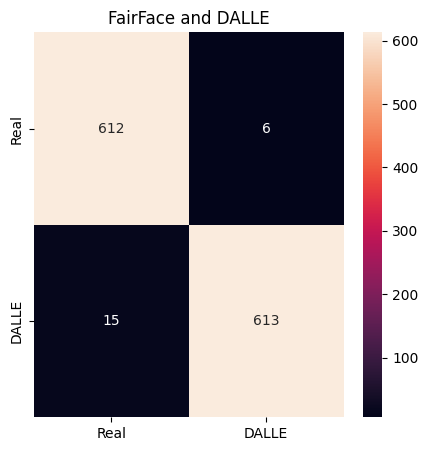

In [ ]:
evaluate_model('/content/drive/MyDrive/fairface_vs_DALLE_128_model.keras',
               '/content/drive/MyDrive/fairface_vs_DALLE_128_hist.pkl',
               x_test, y_test,
               title = "FairFace and DALLE")

##FairFace vs Stable Diff

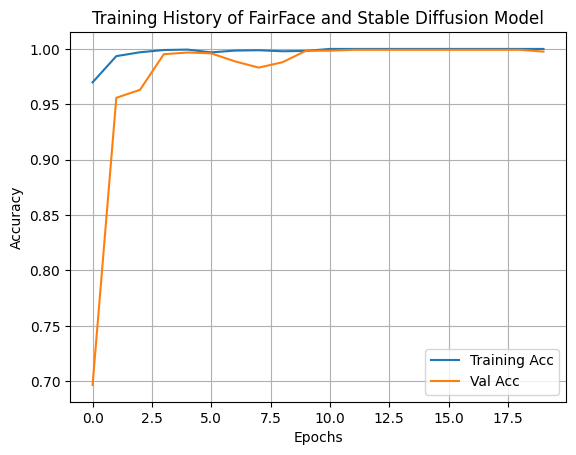

39/39 [==============================] - 0s 5ms/step
         Precision  Recall      F1
Overall     0.9992  0.9992  0.9992
Real        0.9984  1.0000  0.9992
SD          1.0000  0.9984  0.9992


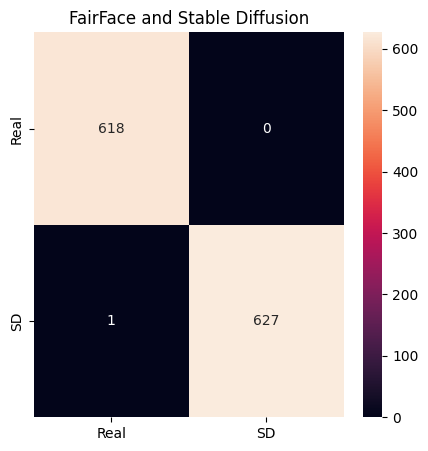

In [ ]:
evaluate_model('/content/drive/MyDrive/fairface_vs_SD_128_model.keras',
               '/content/drive/MyDrive/fairface_vs_SD_128_hist.pkl',
               x_test, y_test,
               title = "FairFace and Stable Diffusion")

##FairFace and Celeb vs DALLE

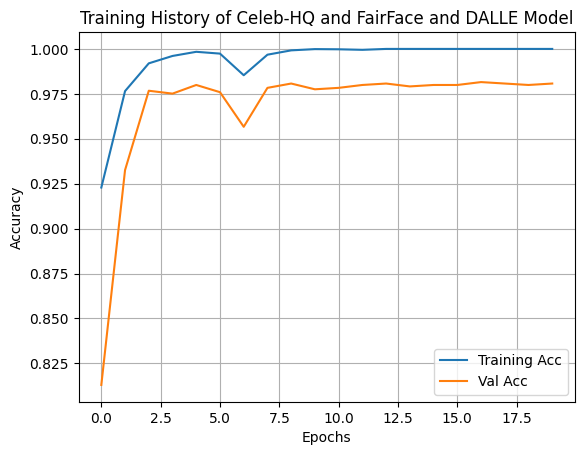

39/39 [==============================] - 0s 5ms/step
         Precision  Recall      F1
Overall     0.9865  0.9864  0.9864
Real        0.9777  0.9951  0.9864
DALLE       0.9951  0.9777  0.9863


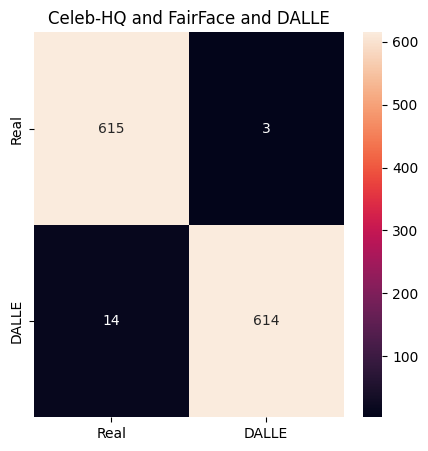

In [ ]:
evaluate_model('/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_128_model.keras',
               '/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_128_hist.pkl',
               x_test, y_test,
               title = "Celeb-HQ and FairFace and DALLE")

##FairFace and Celeb vs DALLE and Stable Diffusion

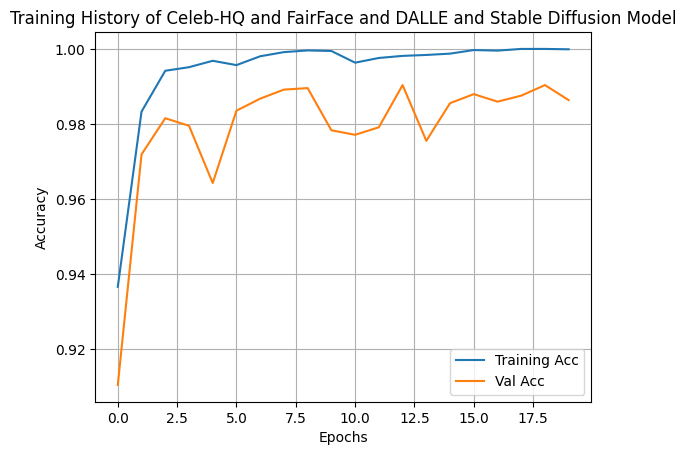

78/78 [==============================] - 1s 7ms/step
         Precision  Recall      F1
Overall     0.9844  0.9843  0.9843
Real        0.9911  0.9776  0.9843
Fake        0.9777  0.9911  0.9844


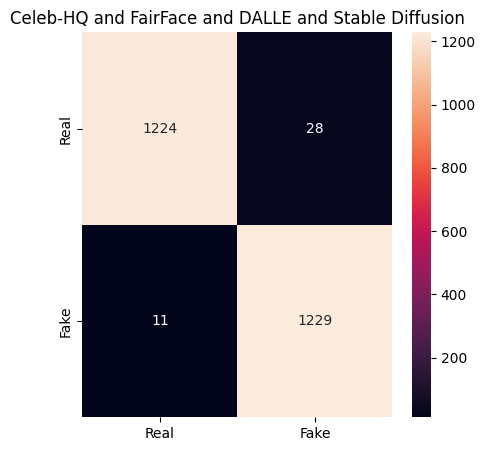

In [ ]:
evaluate_model('/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_and_SD_128_model.keras',
               '/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_and_SD_128_hist.pkl',
               x_test, y_test,
               title = "Celeb-HQ and FairFace and DALLE and Stable Diffusion")

Analyzing Diff categories

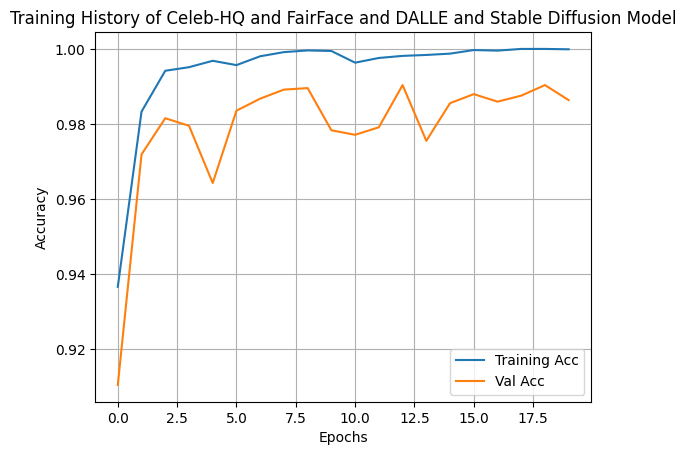

78/78 [==============================] - 1s 6ms/step
58 -> Predicted: 1.0 | Actual: FairFace
178 -> Predicted: 1.0 | Actual: Celeb
198 -> Predicted: 0.0 | Actual: SD
252 -> Predicted: 0.0 | Actual: DALLE
395 -> Predicted: 1.0 | Actual: Celeb
422 -> Predicted: 1.0 | Actual: FairFace
429 -> Predicted: 0.0 | Actual: DALLE
457 -> Predicted: 1.0 | Actual: FairFace
582 -> Predicted: 1.0 | Actual: FairFace
658 -> Predicted: 1.0 | Actual: FairFace
739 -> Predicted: 1.0 | Actual: FairFace
771 -> Predicted: 1.0 | Actual: FairFace
781 -> Predicted: 1.0 | Actual: Celeb
901 -> Predicted: 1.0 | Actual: FairFace
1069 -> Predicted: 1.0 | Actual: FairFace
1071 -> Predicted: 1.0 | Actual: FairFace
1245 -> Predicted: 1.0 | Actual: FairFace
1280 -> Predicted: 1.0 | Actual: FairFace
1369 -> Predicted: 0.0 | Actual: DALLE
1422 -> Predicted: 1.0 | Actual: Celeb
1431 -> Predicted: 1.0 | Actual: FairFace
1436 -> Predicted: 0.0 | Actual: DALLE
1526 -> Predicted: 1.0 | Actual: FairFace
1552 -> Predicted: 0.0 | A

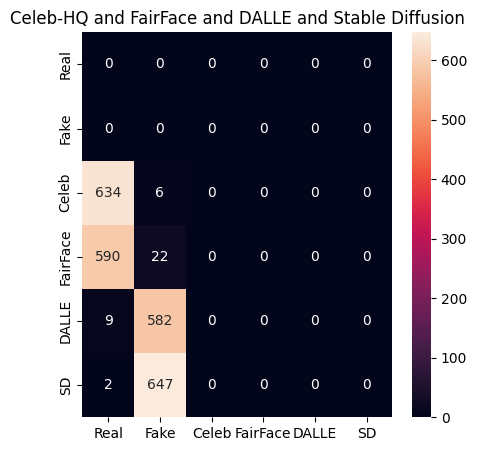

In [ ]:
evaluate_model('/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_and_SD_128_model.keras',
               '/content/drive/MyDrive/celeb_and_fairface_vs_DALLE_and_SD_128_hist.pkl',
               x_test, y_test,
               title = "Celeb-HQ and FairFace and DALLE and Stable Diffusion")

4
(128, 128, 3)


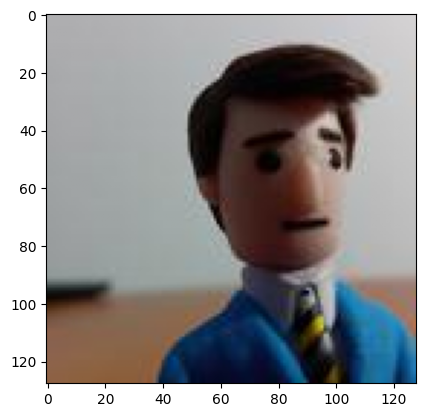

In [ ]:
# print(y_test)
n = 2349
print(y_test[n])
print(x_test[n].shape)
plt.imshow(x_test[n])